# Meta-analysis on the OTIM-DB

Meta-analysis on the OTIM-DB for the effect of land use, tillage, compaction and sampling time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

datadir = '../data/'
outputdir = '../figures/'
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v']

In [2]:
# read in Kunsat database (new structure)
dfdic = pd.read_excel(datadir + 'OTIM-DB.xlsx', sheet_name=None, na_values=[-9999])
dfexp = dfdic['experiments']
dfloc = dfdic['locations']
dfref = dfdic['reference']
dfmeth = dfdic['method'].replace(-9999, np.nan)
dfsp = dfdic['soilProperties']
dfclim = dfdic['climate']
kcols = ['k{:d}'.format(i+1) for i in range(10)]
dfmod = dfdic['modelFit'].rename(columns=dict(zip(kcols, [a.upper() for a in kcols])))
dfsm = dfdic['soilManagement'].replace(-9999, np.nan).replace(
    'no impact', 'consolidated').replace(  # estetic replacement
    'after tillage', 'soon after tillage')

## Check indexes
Check that all indices are unique in each table.

In [3]:
# check indexes are unique
indexes = [
    ('experiment', dfexp, 'MTFName'),
    ('location', dfloc, 'Location'),
    ('reference', dfref, 'ReferenceTag'),
    #('methodTargetFit', dfmtf, 'MTFName'),
    #('soilSiteProperties', dfssp, 'SSPName'),
    ('method', dfmeth, 'MethodName'),
    ('soilProperties', dfsp, 'SPName'),
    ('climate', dfclim, 'ClimateName'),
    ('modelFit', dfmod, 'MTFName'),
    ('soilManagement', dfsm, 'SMName'),
]
for name, df, col in indexes:
    a = df[col].unique().shape[0]
    b = df.shape[0]
    c = 'ok' if a == b else 'not ok => indexes are not unique!'
    print('{:20s}: {:5d} rows with {:5d} unique values: {:s}'.format(name, a, b, c))

experiment          :  1297 rows with  1297 unique values: ok
location            :   205 rows with   205 unique values: ok
reference           :   172 rows with   172 unique values: ok
method              :  1297 rows with  1297 unique values: ok
soilProperties      :  1297 rows with  1297 unique values: ok
climate             :   205 rows with   205 unique values: ok
modelFit            :  1297 rows with  1297 unique values: ok
soilManagement      :  1297 rows with  1297 unique values: ok


In [4]:
# check indexes are all specified (intersection with 'experiment' tab)
for name, df, col in indexes[1:]:
    a = df[col]
    b = dfexp[col]
    ie1 = a.isin(b)
    ie2 = b.isin(a)
    c = 'not ok, some indexes are missing from experiment or ' + name
    if (np.sum(~ie1) == 0) & (np.sum(~ie2) == 0):
        c = 'ok'
    else:
        miss1 = ', '.join(a[~ie1].tolist()) + ' only in ' + name
        miss2 = ', '.join(b[~ie2].tolist()) + ' only in experiment'
        c = 'not ok\n\t' +  miss1 + ';\n\t' + miss2
    print('{:20s} contains {:3d} not related rows, experiment: {:3d} => {:s}'.format(
        name, np.sum(~ie1), np.sum(~ie2), c))

location             contains   0 not related rows, experiment:   0 => ok
reference            contains   0 not related rows, experiment:   0 => ok
method               contains   0 not related rows, experiment:   0 => ok
soilProperties       contains   0 not related rows, experiment:   0 => ok
climate              contains   0 not related rows, experiment:   0 => ok
modelFit             contains   0 not related rows, experiment:   0 => ok
soilManagement       contains   0 not related rows, experiment:   0 => ok


## Filtering entries and aggregation

Entries are kept if:
- they come from topsoil: `UpperD_m` < 0.2 m
- are well fitted: `R2` > 0.9
- measure the full range from 0 mm to 100 mm tension: `Tmax` >= 100 mm and `Tmin` == 0 mm

Entries are aggregated (averaged) if they do no differ according to the columns chosen. Then, all entries aggregated are considered replicates and a standard error is estimated if more than one entries is aggregated.

In [5]:
# merge tables
# NOTE good to merge on specific column (in case same column name appears...)
dflu = dfexp.merge(
    dfloc, how='left', on='Location').merge(
    dfref, how='left', on='ReferenceTag').merge(
    dfmeth, how='left', on='MethodName').merge(
    dfsp, how='left', on='SPName').merge(
    dfclim, how='left', on='ClimateName').merge(
    dfmod, how='left', on='MTFName').merge(
    dfsm, how='left', on='SMName')
dflu = dflu[dflu['ReferenceTag'].ne('kuhwald2017')].reset_index(drop=True)  # remove this entry as only one tension
print('number of entries (rows) initially in the db (as reported in papers):', dflu.shape[0])

# remove entries with R2 lower than 0.9
dflu = dflu[dflu['R2'].ge(0.9)].reset_index(drop=True)
print('number of entries with R2 >= 0.9:', dflu.shape[0])

# remove entries that do not go up to 100 mm tension
ifull = dflu['Tmax'].ge(100) & dflu['Tmin'].le(0)
dflu = dflu[ifull].reset_index(drop=True)
print('number of entries with Tmax >= 100 mm:', dflu.shape[0])

# removing subsoil data
isub = dflu['UpperD_m'].lt(0.2)
dflu = dflu[isub].reset_index(drop=True)
print('number of entries with UpperD < 0.2 m (topsoil):', dflu.shape[0])

# saving
dflu.to_csv(datadir + 'dfotim.csv', index=False)

number of entries (rows) initially in the db (as reported in papers): 1285
number of entries with R2 >= 0.9: 1183
number of entries with Tmax >= 100 mm: 443
number of entries with UpperD < 0.2 m (topsoil): 409


<AxesSubplot:>

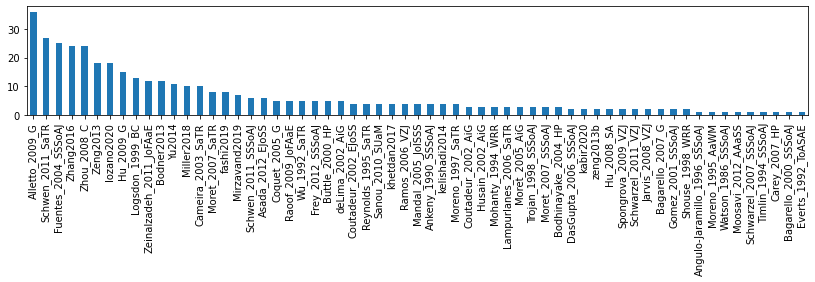

In [6]:
# distribution of number of entries per paper
s = dflu['ReferenceTag'].value_counts()
fig, ax = plt.subplots(figsize=(14, 2))
s.plot.bar(ax=ax)

<AxesSubplot:>

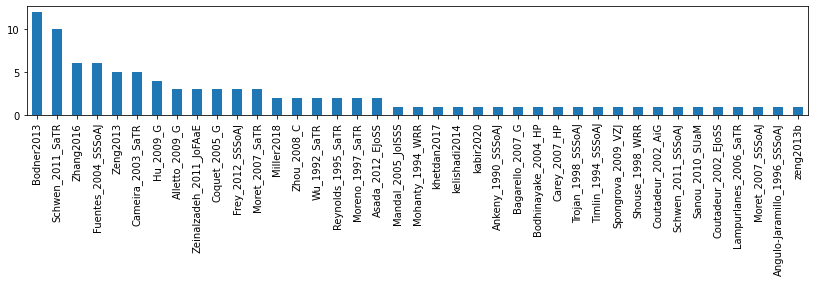

In [7]:
# number of time measurement per paper
sdf = dflu.groupby(['ReferenceTag', 'Month1', 'Month2', 'YearExp']).count().reset_index()
s = sdf['ReferenceTag'].value_counts()
fig, ax = plt.subplots(figsize=(14, 2))
s.plot.bar(ax=ax)

In [8]:
# create classes (so we can use them as categorical variables for aggregation)
print('number of rows after filtering: {:d} ({:d} studies)'.format(
    dflu.shape[0], dflu['ReferenceTag'].unique().shape[0]))

# create classes to enable to average on them
dflu['BulkDensityClass'] = pd.cut(dflu['BulkDensity'], bins=[0, 1, 1.2, 1.4, 1.6, 2]).astype(str)
dflu['BulkDensityClass'] = dflu['BulkDensityClass'].astype(str)  # to set the NaN as 'nan' string
dflu['SoilOrganicCarbonClass'] = pd.cut(dflu['SoilOrganicCarbon'], bins=[0, 0.01, 0.02, 0.03, 0.04, 2]).astype(str)
dflu['SoilOrganicCarbonClass'] = dflu['SoilOrganicCarbonClass'].astype(str)  # to set the NaN as 'nan' string
dflu['AnnualPrecipitationClass'] = pd.cut(dflu['AnnualPrecipitation'], bins=[0, 500, 1000, 1500, 2000, 4000]).astype(str)
dflu['AnnualPrecipitationClass'] = dflu['AnnualPrecipitationClass'].astype(str)
dflu['AnnualMeanTemperatureClass'] = pd.cut(dflu['AnnualMeanTemperature'], bins=[0, 5, 10, 15, 20, 30]).astype(str)
dflu['AnnualMeanTemperatureClass'] = dflu['AnnualMeanTemperatureClass'].astype(str)

number of rows after filtering: 409 (61 studies)


In [9]:
# average studies which do not differentiate according to the columns of interest (aggregation)

practices = [
    'LanduseClass',
    'TillageClass',
#    'NbOfCropRotation',  # not considered because too few studies
#    'ResidueClass',
#    'GrazingClass',
#    'IrrigationClass',
    'CompactionClass',
    'SamplingTimeClass',
    'SoilTextureUSDA',
    #'SoilTypeClass',
    #'AridityClass', # proxy for climate
    'AnnualPrecipitationClass',
    'AnnualMeanTemperatureClass',
    'BulkDensityClass',
    'SoilOrganicCarbonClass',
]

def mode(x):
    # most frequent class
    return x.value_counts(dropna=False).index[0]

# define the operation to be applied on each group
# mean for numeric column, mode for categorical column
dic = {}  # column : function to be applied on the group
colmean = dflu.columns[dflu.dtypes.ne('object')].tolist()
dic.update(dict(zip(colmean, ['mean']*len(colmean))))
colmode = dflu.columns[dflu.dtypes.eq('object')].tolist()
dic.update(dict(zip(colmode, [mode]*len(colmode))))
# for some numeric columns, we just want the sum or the mode, not the mean
dic['Reps'] = 'sum'
for practice in practices:
    dic.pop(practice)
dic.pop('ReferenceTag')

# grouping
dfg = dflu.groupby(['ReferenceTag'] + practices)
df1 = dfg.agg(dic).reset_index()
df2 = dfg.sem().reset_index()  # compute SD from "replicates"
kcols = ['Ks'] + ['K{:d}'.format(a) for a in range(1, 11)]
df = pd.merge(df1, 
              df2[['ReferenceTag'] + practices + kcols], 
              on=['ReferenceTag'] + practices,
              suffixes=('', '_sem')).reset_index()
print('reduction in rows after grouping:', dflu.shape[0], '->', df.shape[0],
     '({:d} studies)'.format(df['ReferenceTag'].unique().shape[0]))

# detecting entries that only contain one row (so not to be used in meta-analysis
# as no paired comparison is possible)
print('number of studies with only one row (useless for meta-analysis, removed):', 
      df['ReferenceTag'].value_counts().le(1).sum(), 'studies')
s = df['ReferenceTag'].value_counts().gt(1)
moreThanOneRow = s[s].index.tolist()
df = df[df['ReferenceTag'].isin(moreThanOneRow)].reset_index(drop=True)
print('total number of rows after removing the reference with only one row:', df.shape[0],
     '({:d} studies)'.format(df['ReferenceTag'].unique().shape[0]))

dflu = df

# it's very difficult to estimate the standard error after aggregation as we often end-up with
# one row per unique combination

# saving
dflu.to_csv(datadir + 'dfotim-averaged.csv', index=False)

reduction in rows after grouping: 409 -> 193 (61 studies)
number of studies with only one row (useless for meta-analysis, removed): 20 studies
total number of rows after removing the reference with only one row: 173 (41 studies)


## Create pairwise comparision
Inside same study, create pairwise comparison with a control value vs other values.

The control values are given a negative number (-1) and the treatment values a positive number (+1). Several treatment values can be compared against the same control. 0 is when the row is not relevant for the comparison.

In [10]:
# let's replace all 'non' arable by 'not arable' so we can use it as control
dflu['LanduseClass'] = dflu['LanduseClass'].replace(
    {'grassland': 'not arable',
     'woodland/plantation': 'not arable',
     'bare': 'not arable'})

In [11]:
# define controles and their values
controls = [ # column, control, column for pairwise
    ('LanduseClass', 'not arable', 'pcLanduse'),
    ('TillageClass', 'no tillage', 'pcTillage'),
    #('NbOfCropRotation', 1, 'pcCropRotation'),
    #('ResidueClass', 'no', 'pcResidues'),
    #('GrazingClass', 'no', 'pcGrazing'),
    #('IrrigationClass', 'rainfed', 'pcIrrigation'),
    ('CompactionClass', 'not compacted', 'pcCompaction'),
    ('SamplingTimeClass', 'consolidated', 'pcSamplingTime'),
]

# replacements to have more homogenized data
# dflu['ResidueClass'] = dflu['ResidueClass'].replace({'no (exact)': 'no'})
# dflu['PastureClassGrazing'] = dflu['PastureClassGrazing'].replace({'no (excat)': 'no'})
# dflu['IrrigationClass'] = dflu['IrrigationClass'].replace({'no': 'rainfed', 'no (exact)': 'rainfed', 'yes': 'irrigated'})
# dflu['CompactionClass'] = dflu['CompactionClass'].replace({'no ':'no', 'inter-row': 'no', 'no (exact)': 'no'})

# for easier interpretation, we regroup 'after compaction' to 'unknown'
dflu['SamplingTimeClass'] = dflu['SamplingTimeClass'].replace('after compaction', 'unknown')

# reps which are nan are set to 1
print('Number of Reps which are NaN or 0 (replaced by 1):', dflu['Reps'].isna().sum() + dflu['Reps'].eq(0).sum())
dflu['Reps'] = dflu['Reps'].replace(0, np.nan).fillna(1)

# unique values per control
for a, b, c in controls:
    print(a, '=>', dflu[a].dropna().unique())

Number of Reps which are NaN or 0 (replaced by 1): 2
LanduseClass => ['arable' 'not arable' 'unknown']
TillageClass => ['conventional tillage' 'reduced tillage' 'no tillage' 'unknown']
CompactionClass => ['unknown' 'compacted' 'not compacted']
SamplingTimeClass => ['consolidated' 'soon after tillage' 'unknown']


In [12]:
# build pair-wise comparison
for a, b, c in controls:
    dflu[c] = 0

# columns that should be similar
cols = np.array(['LanduseClass', # often landuse will change with tillage and crop rotation
                 'TillageClass',
                 #'NbOfCropRotation',
                 #'Crop_class',
                 #'Crop Rotation',
                 #'Covercrop_class',
                 #'ResidueClass',
                 #'GrazingClass',
                 #'IrrigationClass',
                 'CompactionClass',
                 'SamplingTimeClass',
                 #'amendment_class',
                 # measurement date/month
                ])

colsdic = {
    'LanduseClass': cols[5:],
    'TillageClass': cols,
    #'NbOfCropRotation': cols,
    #'ResidueClass': cols,
    #'GrazingClass': cols,
    #'IrrigationClass': cols,
    'CompactionClass': cols,
    'SamplingTimeClass': cols,
}

# build pairwise inside each publication
for pub in dflu['ReferenceTag'].unique():
    ie = dflu['ReferenceTag'] == pub
    irows = np.where(ie)[0]
    for ccol, cval, pcColumn in controls:
        c = 0
        cols = colsdic[ccol]
        colSame = cols[cols != ccol].copy()
        #print('pub==', pub)
        for i in irows:
            row1 = dflu.loc[i, colSame]
            inan1 = row1.isna()
            # if the columns is a controlled value
            if dflu.loc[i, ccol] == cval:
                flag = False
                c = c + 1
                for j in irows:
                    if ((j != i) & (dflu.loc[j, ccol] != cval) &
                       (pd.isna(dflu.loc[j, ccol]) is False) &  # not Nan
                       (dflu.loc[j, ccol] != 'unknown')):  # not unknown
                        row2 = dflu.loc[j, colSame]
                        inan2 = row2.isna()
                        #if cval == 'rainfed':
                            #print('1-', pub, row1.values)
                            #print('2-', pub, row2.values)
                        if row1.eq(row2)[~inan1 & ~inan2].all():
                            dflu.loc[i, pcColumn] = -c
                            dflu.loc[j, pcColumn] = c
                            #if cval == 'rainfed':
                           #     print('ok')

for a, b, c in controls:
    print(c, np.sum(dflu[c] > 0))
dflu.to_excel(datadir + 'dflu.xlsx', index=False)

pcLanduse 24
pcTillage 32
pcCompaction 8
pcSamplingTime 12


## Effect sizes
Effect sizes (ES) are computed according to this formula:

$$ \text{ES} = \text{LRR} = \log_{10}\big(\frac{\text{Treatment}}{\text{Control}}\big)$$

with $W_i$ as:

$$W_i = \frac{\text{Reps control * Reps treatment}}{\text{Reps control + Reps treatment}}$$

For easier interpretation, we can convert back to a change in percent:

$$ (10^{ES}-1)*100$$

If the effect size is greater than 0, that means the treatment is larger than the control.

The weighted mean is computed as:

$$ \bar{ES} = \frac{\sum_{i=1}^n w_i\text{LRR}_i}{\sum_{i=1}^n w_i}$$

And the weighted variance of the mean as:

$$ Var{(\bar{ES})} = \frac{\sigma_{LLR}^2\sum_{i=1}^n w_i^2}{(\sum_{i=1}^n w_i)^2}$$

and the standard error of the mean:

$$ \frac{\sigma_{LLR}\sqrt{\sum_{i=1}^n w_i^2}}{\sum_{i=1}^n w_i}$$

In [13]:
# compute effect sizes
kcols = ['Ks'] + ['K{:d}'.format(a) for a in range(1, 11)]
esColumns = ['es' + a[2][2:] for a in controls]
for c in esColumns:
    dflu[c] = np.nan
for pub in dflu['ReferenceTag'].unique():
    ie = dflu['ReferenceTag'] == pub
    for ccol, cval, pcColumn in controls:
        esColumn = 'es' + pcColumn[2:]
        for i in range(np.sum(ie)):
            ieTrt = dflu[pcColumn] == (i+1)
            itrts = np.where(ie & ieTrt)[0]
            if len(itrts) > 0:
                ieCtl = dflu[pcColumn] == -(i+1)
                ictl = np.where(ie & ieCtl)[0][0]
                mtfNameCtl = dflu[ie & ieCtl]['SMName'].values[0]
                controlValues = dflu[ie & ieCtl][kcols].values[0, :]
                controlReps = dflu[ie & ieCtl]['Reps'].values[0]
                for itrt in itrts:
                    mtfNameTrt = dflu.loc[itrt, 'SMName']
                    treatmentValues = dflu.loc[itrt, kcols].astype(float).values
                    treatmentReps = dflu.loc[itrt, 'Reps']
                    escols = [esColumn + '_' + a for a in kcols]
                    dflu.loc[itrt, escols] = np.log10(treatmentValues/controlValues)  # effect size
                    #dflu.loc[itrt, escols] = ((treatmentValues/controlValues) - 1)*100  # effect size
                    dflu.loc[itrt, esColumn] = dflu.loc[itrt, esColumn + '_K10']  # the one we use by default
                    dflu.loc[itrt, 'wi'] = (controlReps * treatmentReps)/(controlReps + treatmentReps)  # weight
print('Number of unassigned rows:', np.sum((dflu[[a[2] for a in controls]] == 0).all(1)))

Number of unassigned rows: 60


In [14]:
# table for paper
f2text = {
    'Landuse': 'Land use',
    # todo or just modify in the paper
}
df = pd.DataFrame(columns=['Factor', 'Control', 'Treatments', 'Studies', 'Paired comparisons'])
for a, b, c in controls:
    treatments = dflu[a].replace('unknown', pd.NA).replace(0, pd.NA).dropna().unique().tolist()
    treatments.remove(b)
    if c == 'pcCropRotation':
        treatments = ['{:.0f}'.format(d) for d in treatments]
    esColumn = 'es' + c[2:]  # use esXXX rather than pcXXX columns as 1 es = 1 pairwise comparison
    dfstudy = dflu[['ReferenceTag', esColumn]].copy()
    dfstudy = dfstudy[dfstudy[esColumn].notnull()].reset_index(drop=True)
    nstudy = dfstudy['ReferenceTag'].unique().shape[0]
    df = df.append({
        'Factor': a.replace('Class', ''),
        'Control': b,
        'Treatments': ', '.join(treatments),
        'Studies': nstudy,
        'Paired comparisons': dfstudy.shape[0],
    }, ignore_index=True)
df.style.hide_index()

Factor,Control,Treatments,Studies,Paired comparisons
Landuse,not arable,arable,10,24
Tillage,no tillage,"conventional tillage, reduced tillage",15,32
Compaction,not compacted,compacted,6,8
SamplingTime,consolidated,soon after tillage,6,12


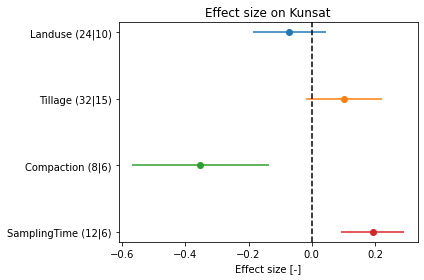

In [15]:
# plot effect sizes
esColumns = ['es' + a[2][2:] for a in controls]
fig, ax = plt.subplots()
ax.set_title('Effect size on Kunsat')
ylabs = []
ax.axvline(0, linestyle='--', color='k')
for i, esColumn in enumerate(esColumns):
    df = dflu[dflu[esColumn].notnull()]
    #print(esColumn, dflu[esColumn].mean())
    ax.errorbar((df[esColumn]*df['wi']).sum()/df['wi'].sum(),  # weighting or not weighting?
                i, xerr=(df[esColumn].std()*np.sqrt(df['wi'].pow(2).sum()))/df['wi'].sum(),
                #df[esColumn].mean(), i, xerr=df[esColumn].sem(),
                marker='o', label=esColumn[2:])
    ylabs.append('{:s} ({:d}|{:d})'.format(esColumn[2:], dflu[esColumn].notnull().sum(),
                                          dflu[dflu[esColumn].notnull()]['ReferenceTag'].unique().shape[0]))
ax.set_xlabel('Effect size [-]')
ax.set_yticks(np.arange(len(ylabs)))
ax.set_yticklabels(ylabs)
ax.invert_yaxis()
#ax.legend()
fig.tight_layout()
fig.savefig(outputdir + 'meta.jpg', dpi=500)

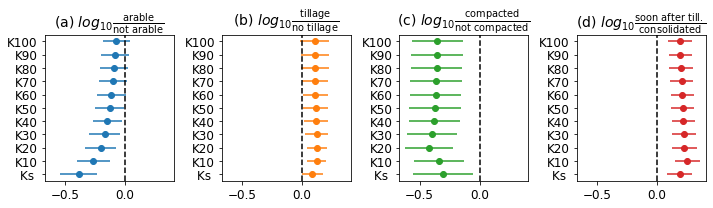

In [17]:
# plot effect sizes
esColumns = ['es' + a[2][2:] for a in controls]
titles = [
    r'(a) $log_{10}\frac{\mathrm{arable}}{\mathrm{not\ arable}}$',
    r'(b) $log_{10}\frac{\mathrm{tillage}}{\mathrm{no\ tillage}}$',
    r'(c) $log_{10}\frac{\mathrm{compacted}}{\mathrm{not\ compacted}}$',
    r'(d) $log_{10}\frac{\mathrm{soon\ after\ till.}}{\mathrm{consolidated}}$']
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=False)
axs = axs.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, esColumn in enumerate(esColumns):
    ax = axs[i]
    #ax.set_title('({:s}) {:s}'.format(letters[i], esColumn[2:]))
    ax.set_title(titles[i], fontsize=14)
    ax.axvline(0, linestyle='--', color='k')
    ylabs = []
    for j, kcol in enumerate(kcols):
        col = esColumn + '_' + kcol
        #cax = ax.errorbar(dflu[col].mean(), j, xerr=dflu[col].sem(), marker='o', color=colors[i])
        df = dflu[dflu[col].notnull()]
        cax = ax.errorbar((df[col]*df['wi']).sum()/df['wi'].sum(),
                j, xerr=(df[col].std()*np.sqrt(df['wi'].pow(2).sum()))/df['wi'].sum(),
            marker='o', color=colors[i])
        # ylabs.append('{:3s}{:>9s}'.format(kcol,
        #         '({:d}|{:d})'.format(dflu[col].notnull().sum(),
        #         dflu[dflu[col].notnull()]['ReferenceTag'].unique().shape[0])))
        if j > 0:
            ylabs.append('{:3s}'.format(kcol+'0'))
        else:                
            ylabs.append('{:3s}'.format(kcol))
        
    ax.set_yticks(np.arange(len(ylabs)))
    ax.set_yticklabels(ylabs, ha='right')
    if i > 3:
        ax.set_xlabel('Effect size [-]')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
fig.tight_layout()
fig.savefig(outputdir + 'meta-all-k.jpg', dpi=500)

## Sensitivity

To estimate the robustness of the computed average effect size, we repeatedly removed one (two, three, ...) studies and computed back the mean ES. When X studies were removed, the X studies were randomly picked. This random picking was repeated for N realizations. For each realization the mean ES was computed. At the end, the mean and standard deviation of the mean of the N average ES obtained for all realizations is computed [(Basche and deLong, 2019)](https://doi.org/10.1371/journal.pone.0215702).

In [19]:
# passing variables
escols = ['esLanduse_K10', 'esTillage_K10', 'esCompaction_K10', 'esSamplingTime_K10',
          'esLanduse_Ks', 'esTillage_Ks', 'esCompaction_Ks', 'esSamplingTime_Ks']
df = dflu

In [20]:
# sensitivity of effect sizes per study with a Jacknife technique (Basche and deLonge 2019)
dfsens = pd.DataFrame()
for col in escols:
    ie = df[col].notnull()
    studies = df[ie]['ReferenceTag'].unique()
    sdf = df[ie]
    mean = (sdf[col]*sdf['wi']).sum()/sdf['wi'].sum()
    sem = 0
    dfsens = dfsens.append({'var': col.replace('_ES',''), 'nexcl': 0, 'mean': mean,
                            'sem': sem, 'n': np.sum(ie), 'nstudy': len(studies)},
                            ignore_index=True)
    for i in range(1, 10):  # need to start at 1 with this method
        means = []
        sems = []
        if i < len(studies):
            for j in range(50):
                # doing all combinations is not possible so we just take out studies
                # randomly without replacement and we repeat this a number of times
                studyOut = studies[np.random.choice(len(studies), size=i, replace=False)]
                i2keep = ~df['ReferenceTag'].isin(studyOut)
                ie2 = ie & i2keep
                #mean, sem = df[ie2][col].mean(), df[ie2][col].sem()  # not weighted
                sdf = df[ie2]
                mean = (sdf[col]*sdf['wi']).sum()/sdf['wi'].sum()
                sem = (sdf[col].std()*np.sqrt(sdf['wi'].pow(2).sum()))/sdf['wi'].sum()
                means.append(mean)
                sems.append(sem)
            mean = np.mean(means)
            sem = np.mean(sem)
#           sem = np.std(vals)/np.sqrt(len(vals))  # this becomes tiny as we repeat more
            nstudy = len(studies) - i
            dfsens = dfsens.append({'var': col.replace('_ES',''), 'nexcl': i, 'mean': mean,
                                    'sem': sem, 'n': np.sum(ie2), 'nstudy': nstudy},
                                   ignore_index=True)
dfsens.head()

,var,nexcl,mean,sem,n,nstudy
0,esLanduse_K10,0.0,-0.070996,0.000000,24.0,10.0
1,esLanduse_K10,1.0,-0.062354,0.130024,21.0,9.0
2,esLanduse_K10,2.0,-0.063771,0.104065,20.0,8.0
3,esLanduse_K10,3.0,-0.073570,0.164057,16.0,7.0
4,esLanduse_K10,4.0,-0.048417,0.146076,14.0,6.0


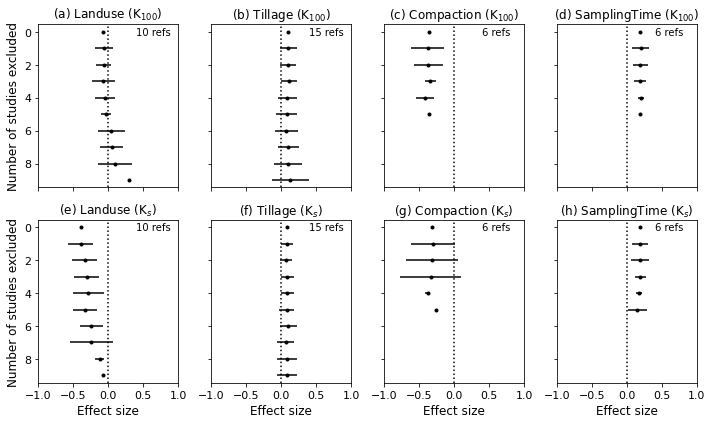

In [28]:
# sensitivity graphs
fig, axs = plt.subplots(2, 4, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
ts = [r'K$_{100}$', r'K$_{100}$', r'K$_{100}$', r'K$_{100}$', 
      r'K$_s$', r'K$_s$', r'K$_s$',r'K$_s$']
for i, variable in enumerate(escols):
    ax = axs[i]
    ie = dfsens['var'] == variable
    ie0 = dfsens['nexcl'] == 0
    ax.set_title('({:s}) {:s} ({:s})'.format(
        letters[i], variable[2:].split('_')[0], ts[i]))# variable.split('_')[1]))
    ax.annotate('{:.0f} refs'.format(
        dfsens[ie & ie0]['nstudy'].values[0]), (0.4, 0.2))
    ax.errorbar(dfsens[ie]['mean'], dfsens[ie]['nexcl'], xerr=dfsens[ie]['sem'],
                marker='.', linestyle='none', color='k')
    if i > 3:
        ax.set_xlabel('Effect size', fontsize=12)
    if i % 4 == 0:
        ax.set_ylabel('Number of studies excluded', fontsize=12)
    ax.axvline(0, color='k', linestyle=':')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(11)
ax.set_xlim([-1, 1]);
ax.invert_yaxis()
fig.tight_layout()
fig.savefig(outputdir + 'meta-sensitivity.jpg', dpi=500)

## Publication bias
As no SD was available, we looked at the publication bias by simply plotting the histogram of the effect size. The deviation from of the shape of the histogram from a normal distribution can be a sign of publication bias.

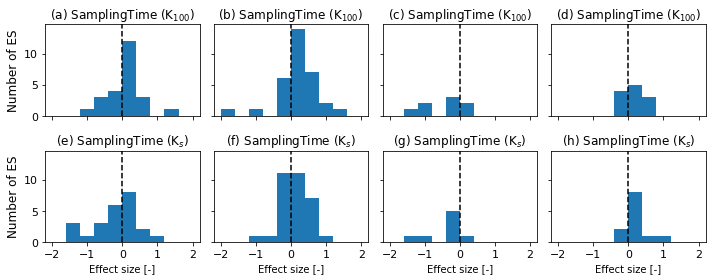

In [27]:
# another approach is to just plot the histogram of effect sizes
fig, axs = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
axs = axs.flatten()
bins = np.linspace(-2, 2, 11)
ts = [r'K$_{100}$', r'K$_{100}$', r'K$_{100}$', r'K$_{100}$', 
      r'K$_s$', r'K$_s$', r'K$_s$',r'K$_s$']
for i, esColumn in enumerate(escols):
    ax = axs[i]
    ax.set_title('({:s}) {:s} ({:s})'.format(
        letters[i], variable[2:].split('_')[0], ts[i]))# variable.split('_')[1]))
    ax.hist(dflu[esColumn].dropna().values, bins=bins)
    ax.axvline(0, color='k', linestyle='--')
    if i >= 4:
        ax.set_xlabel('Effect size [-]')
    if i % 4 == 0:
        ax.set_ylabel('Number of ES', fontsize=12)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(11)
fig.tight_layout()
fig.savefig(outputdir + 'hist-es.jpg', dpi=500)

## Heterogeneity

How much effect size varies according to different sub categories. So using other columns to dissect the ES in subgroups of interest (after/before disturbance for instance) or by soil type.

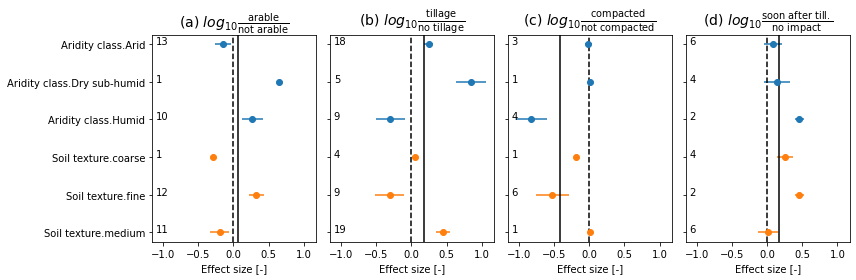

In [21]:
# TODO disc size, soil texture fao, sampling time, soc classes, aridity class, with/without cover crops

# create classes
dflu['Aridity class'] = dflu['AridityClass'].replace({'Hyper Arid': 'Arid', 'Semi-Arid': 'Arid'})
dflu['Annual precipitation'] = pd.cut(dflu['AnnualPrecipitation'], bins=[0, 200, 400, 600, 2000])
dflu['Annual mean temperature'] = pd.cut(dflu['AnnualMeanTemperature'], bins=[0, 10, 15, 30])
gcol = 'SoilTextureUSDA'
def func(x):
    dico = {
        'unknown': np.nan,
        np.nan: np.nan,
        'organic': np.nan,
        'clay': 'fine',
        'clay loam': 'fine',
        'loam': 'medium',
        'loamy sand': 'coarse',
        'sand': 'coarse',
        'sandy clay': 'coarse',
        'sandy clay loam': 'coarse',
        'sandy loam': 'coarse',
        'silt loam': 'medium',
        'silty clay': 'fine',
        'silty clay loam': 'fine'
    }
    return dico[x]
dflu['Soil texture'] = dflu['SoilTextureUSDA'].apply(func)
dflu['Soil organic carbon'] = pd.cut(dflu['SoilOrganicCarbon'], bins=[0.0, 0.01, 0.02, 0.03, 0.1])


# figure
#colgroup = ['Aridity class', 'Annual precipitation', 'Annual mean temperature', 'Soil texture', 'Soil organic carbon']
colgroup = ['Aridity class', 'Soil texture']
titles = [
    r'(a) $log_{10}\frac{\mathrm{arable}}{\mathrm{not\ arable}}$',
    r'(b) $log_{10}\frac{\mathrm{tillage}}{\mathrm{no\ tillage}}$',
    r'(c) $log_{10}\frac{\mathrm{compacted}}{\mathrm{not\ compacted}}$',
    r'(d) $log_{10}\frac{\mathrm{soon\ after\ till.}}{\mathrm{no\ impact}}$']
fig, axs = plt.subplots(1, len(esColumns), sharex=True, sharey=True, figsize=(12, 4))
axs = axs.flatten()
for i, esColumn in enumerate(esColumns):
    ax = axs[i]
    # ax.set_title('({:s})\n'.format(letters[i]) + esColumn[2:] +
    #             '\n({:d}|{:d})'.format(dflu[esColumn].notnull().sum(),
    #             dflu[dflu[esColumn].notnull()]['ReferenceTag'].unique().shape[0]))
    ax.set_title(titles[i], fontsize=14)
    y = 0
    ylabs = []
    ax.axvline(0, linestyle='--', color='k')
    ax.axvline(dflu[esColumn].mean(), color='k')
    for col in colgroup:
        dfg = dflu.groupby(col)
        color = None
        for key, group in dfg:
            if (group[esColumn].notnull().sum() > 0) and (key != 'unknown'):
                cax = ax.errorbar(group.mean()[esColumn], 
                                  xerr=group.sem()[esColumn],
                                  y=y, marker='o', color=color)
                ax.text(-1.1, y, str(group[esColumn].notnull().sum()))
                if color is None:
                    color = cax[0].get_color()
                y += 1
                ylabs.append(col + '.' + str(key))# + ' ({:d})'.format(group[esColumn].dropna().shape[0]))
    ax.set_xlabel('Effect size [-]')
    if i == 0:
        ax.set_yticks(np.arange(len(ylabs)))
        ax.set_yticklabels(ylabs)
        ax.invert_yaxis()
fig.tight_layout()
fig.savefig(outputdir + 'split-es.jpg', dpi=500)

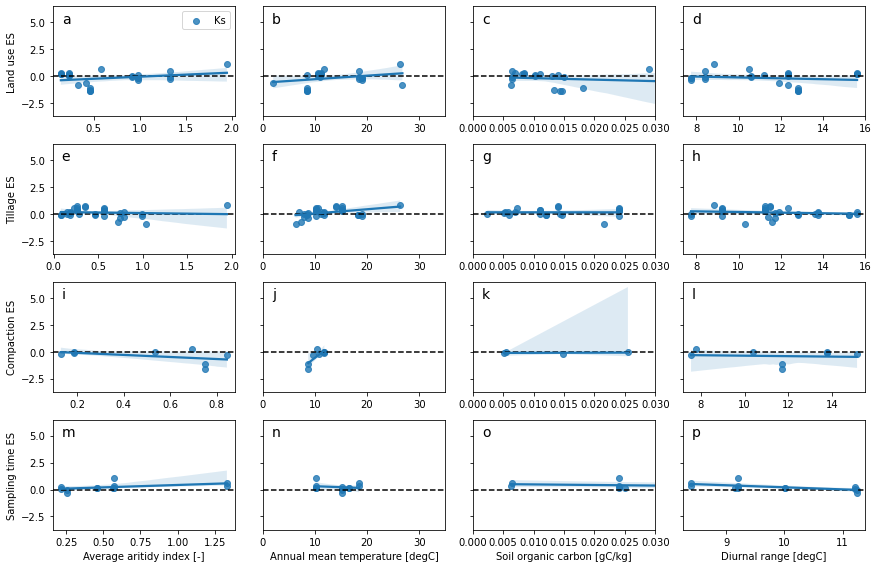

In [22]:
# meta-regression are more adapted for continuous variable
hcols = {
    'AverageAridityIndex': ['Average aritidy index [-]', None, None],
    #'AnnualPrecipitation': ['Mean annual precipitation [mm]', 0, 2000],
    'AnnualMeanTemperature': ['Annual mean temperature [degC]', 0, 35],
    'SoilOrganicCarbon': ['Soil organic carbon [gC/kg]', 0, 0.03],
    'MeanDiurnalRange': ['Diurnal range [degC]', None, None]
}
kcols = ['Ks']
practices = {
    'Landuse': 'Land use',
    'Tillage': 'Tillage',
    'Compaction': 'Compaction',
    'SamplingTime': 'Sampling time'
}

fig, axs = plt.subplots(len(practices), len(hcols), sharey=True, figsize=(12, 8))
for i, prac in enumerate(practices):
    for j, xcol in enumerate(hcols):
        ylab = practices[prac]
        ax = axs[i, j]
        ax.axhline(0, linestyle='--', color='k')
        ax.annotate(letters[i*len(practices)+j], (0.05, 0.85), xycoords='axes fraction', fontsize=14)
        for kcol in kcols:
            ycol = 'es' + prac + '_' + kcol
#            ax.plot(dflu[xcol], dflu[ycol], 'o', label=kcol)
            sns.regplot(x=dflu[xcol], y=dflu[ycol], label=kcol, ax=ax)
        if j == 0:
            ax.set_ylabel(ylab + ' ES')
        else:
            ax.set_ylabel('')
        ax.set_xlim(hcols[xcol][1:])
        if i == len(hcols) - 1:
            ax.set_xlabel(hcols[xcol][0])
        else:
            ax.set_xlabel('')
        if i == 0 and j == 0:
            ax.legend()
fig.tight_layout()
fig.savefig(outputdir + 'meta-regression-ks.jpg', dpi=500)

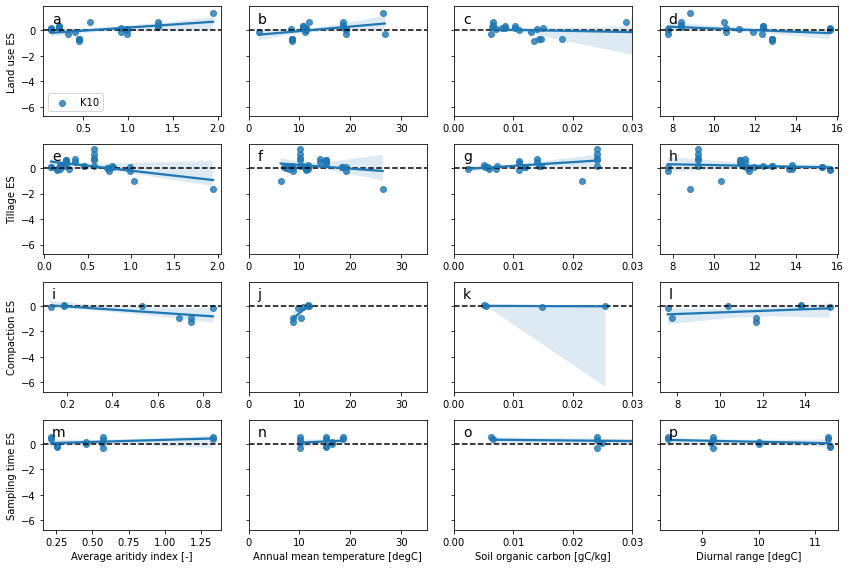

In [23]:
# meta-regression are more adapted for continuous variable
hcols = {
    'AverageAridityIndex': ['Average aritidy index [-]', None, None],
    #'AnnualPrecipitation': ['Mean annual precipitation [mm]', 0, 2000],
    'AnnualMeanTemperature': ['Annual mean temperature [degC]', 0, 35],
    'SoilOrganicCarbon': ['Soil organic carbon [gC/kg]', 0, 0.03],
    'MeanDiurnalRange': ['Diurnal range [degC]', None, None]
}
kcols = ['K10']
practices = {
    'Landuse': 'Land use',
    'Tillage': 'Tillage',
    'Compaction': 'Compaction',
    'SamplingTime': 'Sampling time'
}

fig, axs = plt.subplots(len(practices), len(hcols), sharey=True, figsize=(12, 8))
for i, prac in enumerate(practices):
    for j, xcol in enumerate(hcols):
        ylab = practices[prac]
        ax = axs[i, j]
        ax.axhline(0, linestyle='--', color='k')
        ax.annotate(letters[i*len(practices)+j], (0.05, 0.85), xycoords='axes fraction', fontsize=14)
        for kcol in kcols:
            ycol = 'es' + prac + '_' + kcol
#            ax.plot(dflu[xcol], dflu[ycol], 'o', label=kcol)
            sns.regplot(x=dflu[xcol], y=dflu[ycol], label=kcol, ax=ax)
        if j == 0:
            ax.set_ylabel(ylab + ' ES')
        else:
            ax.set_ylabel('')
        ax.set_xlim(hcols[xcol][1:])
        if i == len(hcols) - 1:
            ax.set_xlabel(hcols[xcol][0])
        else:
            ax.set_xlabel('')
        if i == 0 and j == 0:
            ax.legend()
fig.tight_layout()
fig.savefig(outputdir + 'meta-regression-k10.jpg', dpi=500)

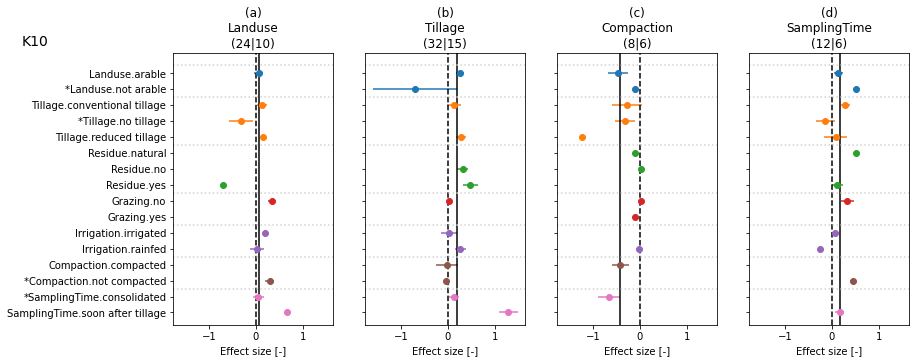

In [24]:
# figure of pure interactions
dflu['NbOfCropRotationStr'] = dflu['NbOfCropRotation'].astype(str)
colgroup = ['LanduseClass', 'TillageClass', 'ResidueClass', 
            'GrazingClass', 'IrrigationClass', 'CompactionClass', 'SamplingTimeClass']
fig, axs = plt.subplots(1, len(esColumns), sharex=True, sharey=True, figsize=(14, 5))
axs = axs.flatten()
plt.text(0.02, 0.9, 'K10', fontsize=14, transform=plt.gcf().transFigure)
for i, esColumn in enumerate(esColumns):
    ax = axs[i]
    ax.set_title('({:s})\n'.format(letters[i]) + esColumn[2:] +
                '\n({:d}|{:d})'.format(dflu[esColumn].notnull().sum(),
                dflu[dflu[esColumn].notnull()]['ReferenceTag'].unique().shape[0]))
    y = 0
    ylabs = []
    ax.axvline(0, linestyle='--', color='k')
    #ax.errorbar(dflu[esColumn].mean(), 0, xerr=dflu[esColumn].sem(), color='k', marker='o')
    ax.axvline(dflu[esColumn].mean(), color='k')
    #ylabs.append('Grand mean')
    for col in colgroup:
        dfg = dflu.groupby(col)
        color = None
        ax.axhline(y-0.5, linestyle=':', color='lightgrey')
        for key, group in dfg:
            if (group.shape[0] > 3) and (key != 'unknown'):
                cax = ax.errorbar(group.mean()[esColumn],
                                  xerr=group.sem()[esColumn],
                                  y=y, marker='o', color=color)
                if color is None:
                    color = cax[0].get_color()
                y += 1
                #ylabs.append('{:*<15s} {:*>15s}'.format(col.replace('Class', ''), key))
                ylab = '{:s}.{:s}'.format(col.replace('Class', ''), key)
                for row in controls:
                    if row[0] == col and row[1] == key:
                        ylab = '*' + ylab
                        break
                ylabs.append(ylab)
    ax.set_xlabel('Effect size [-]')
    if i == 0:
        ax.set_yticks(np.arange(len(ylabs)))
        ax.set_yticklabels(ylabs)
        ax.invert_yaxis()
#fig.tight_layout()
fig.subplots_adjust(left=0.17)
fig.savefig(outputdir + 'split-es-col.jpg', dpi=500)